# Binary QSAR in Python - LabMol

Developed by: 
#### José Teófilo Moreira Filho

#  <font color='white'> Model building with morgan fingerprint and RF, SVM and LightGBM </font>

In [ ]:
import datetime
now = datetime.datetime.now()
print("date of creation:\n", now)

In [2]:
# Importing packages 
from rdkit import Chem, DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import PandasTools

import numpy as np
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import DataFrame

import os

import xgboost as xgb
import lightgbm as lgb

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, roc_curve, precision_recall_curve, roc_auc_score, make_scorer
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import auc as mauc
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import TomekLinks

import multiprocessing

from skopt import BayesSearchCV

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Check initial number of compounds

In [3]:
# Reading molecules and activity (0 and 1) from SDF
fname = "../data/1224857_bruno_imbalanced.sdf"

In [4]:
df0 = PandasTools.LoadSDF(fname, smilesName='SMILES', includeFingerprints=False)

In [5]:
df0.columns

Index(['Outcome', 'pIC50', 'ID', 'SMILES', 'is_active', 'ROMol'], dtype='object')

In [6]:
df0["is_active"] = np.where(df0["Outcome"] == "Active", 1,0)

,Outcome,pIC50,ID,SMILES,is_active,ROMol
0,Inactive,4.861056598092725,,O=c1c(-c2ccc(O)cc2)coc2cc(O)ccc12,0,
1,Inactive,4.811057461628963,,N#C/C(=C\c1ccc(O)c(O)c1)C(=O)Nc1ccccc1,0,
2,Inactive,4.811057461628963,,Cc1csc(NC(=O)c2sc3nc4c(c(C(F)(F)F)c3c2N)CCC4)n1,0,
3,Inactive,4.650000220873454,,CC(C)(C)COc1ccc(-n2cc(C(=O)O)cn2)cc1C#N,0,
4,Inactive,4.7610561120364965,,CC(=O)Nc1ccc(C(C)C(=O)Nc2ncc(C(C)C)s2)cc1,0,

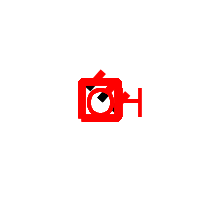
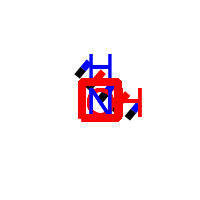
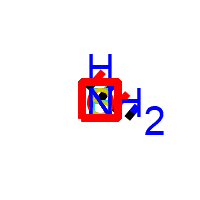
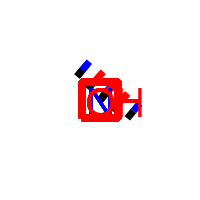
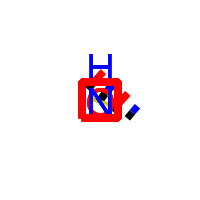

In [7]:
df0.head()

Class 0: 3478
Class 1: 43
Proportion: 80.88 : 1


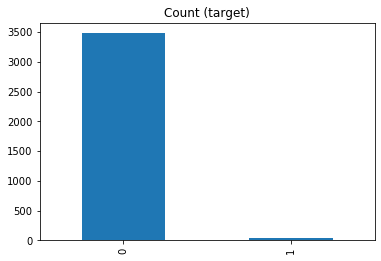

In [8]:
target_count = df0.is_active.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [9]:
#Save the table as SD file
#PandasTools.WriteSDF(df0, '../data/w2_isactive_5445.sdf', properties=df0.columns)

## Fingerprint calculation

In [11]:
# Reading molecules and activity (0 and 1) from SDF
fname = "../data/1224857_bruno_imbalanced_prep.sdf"

mols = []
y = []
for mol in Chem.SDMolSupplier(fname):
    if mol is not None:
        mols.append(mol)
        y.append(mol.GetIntProp("is_active")) # target column

In [12]:
# Calculate descriptors (fingerprints) and convert them into numpy array

# generate binary morgan fingerprint with radius 2
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048, useFeatures=False) for m in mols]

def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [13]:
x = rdkit_numpy_convert(fp)

In [14]:
# Check the number of compounds
len(x)

3521

In [15]:
# check wether the data set is balanced
sum(y) / len(y)

0.012212439647827322

## Data splitting

In [16]:
#Create folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## RF Model building - Bayesian hyperparameter search  

In [17]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_rf = BayesSearchCV(
    RandomForestClassifier(),
    {'max_features': ['auto', 'sqrt'],
    'n_estimators': [100, 1000],
    "max_depth": [2, 100],
    'min_samples_leaf': [1,20], 
    'min_samples_split': [2, 20]
    },
    n_iter=50, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    verbose=0,
    refit= True, # Refit the best estimator with the entire dataset.
    random_state=42, 
    n_jobs = -1
)

opt_rf.fit(x, y)

print("Best parameters: %s" % opt_rf.best_params_)

Best parameters: OrderedDict([('max_depth', 42), ('max_features', 'sqrt'), ('min_samples_leaf', 19), ('min_samples_split', 8), ('n_estimators', 703)])


## 5-fold cross-validation

In [18]:
probs_classes = []
#indexes = []
y_test_all = []

for train_index, test_index in cv.split(x, y):
    rf_clf = RandomForestClassifier(**opt_rf.best_params_) # model with best parameters
    X_train_folds = x[train_index] # descritors train split
    y_train_folds = np.array(y)[train_index.astype(int)] # label train split
    X_test_fold = x[test_index] # descritors test split
    y_test_fold = np.array(y)[test_index.astype(int)] # label test split
    
    
    rf_clf.fit(X_train_folds, y_train_folds) # train fold
    y_pred = rf_clf.predict_proba(X_test_fold) # test fold
    probs_classes.append(y_pred) # all predictions for test folds
    y_test_all.append(y_test_fold) # all folds' labels 
#   indexes.append(test_index) # all tests indexes

## Check performance of each fold

In [19]:
# Get predictions of each fold
fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

In [20]:
# Get experimental values of each fold
fold_1_exp = y_test_all[0]
fold_2_exp = y_test_all[1]
fold_3_exp = y_test_all[2]
fold_4_exp = y_test_all[3]
fold_5_exp = y_test_all[4]

In [21]:
bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
print("Balanced accuracy (fold 1) = ", bacc1)
print("Balanced accuracy (fold 2) = ", bacc2)
print("Balanced accuracy (fold 3) = ", bacc3)
print("Balanced accuracy (fold 4) = ", bacc4)
print("Balanced accuracy (fold 5) = ", bacc5)

Balanced accuracy (fold 1) =  0.5
Balanced accuracy (fold 2) =  0.5
Balanced accuracy (fold 3) =  0.5
Balanced accuracy (fold 4) =  0.5
Balanced accuracy (fold 5) =  0.5


## Check mean performance of folds

In [22]:
probs_classes = np.concatenate(probs_classes)    
y_experimental = np.concatenate(y_test_all)

In [23]:
# Uncalibrated model predictions
pred_rf = (probs_classes[:, 1] > 0.5).astype(int)

### Statistics - morgan-RF

In [24]:
def calc_statistics(y,pred):
    # save confusion matrix and slice into four pieces
    confusion = confusion_matrix(y, pred)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # Plot confusion
    #plt.figure(figsize=(5,5))
    #sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    #plt.ylabel('Actual label');
    #plt.xlabel('Predicted label');
    #title = "Confusion matrix"
    #plt.title(title, size = 15);
    
    # calc statistics
    classification_error = round(1 - accuracy_score(y, pred),2) #Classification error or misclassification rate
    accuracy = round(accuracy_score(y, pred),2)#accuracy
    mcc = round(matthews_corrcoef(y, pred),2) #mcc
    kappa = round(cohen_kappa_score(y, pred),2) #kappa
    sensitivity = round(recall_score(y, pred),2) #Sensitivity
    specificity = round(TN / (TN + FP),2) #Specificity
    false_positive_rate = round(FP / float(TN + FP),2) #False positive rate (alfa)
    false_negative_rate = round(FN / float(TP+FN),2) #False negative rate (beta)
    #precision = round(TP / float(TP + FP),2) #Precision
    positive_pred_value = round(TP / float(TP + FP),2) #PPV
    negative_pred_value = round(TN / float(TN + FN),2) #NPV
    auc = round(roc_auc_score(y, pred),2) #AUC
    bacc = round(balanced_accuracy_score(y, pred),2) # balanced accuracy
    f1 = round(f1_score(y, pred),2) # F1-score

    """"print("Accuracy = ", accuracy)
    print("MCC = ", mcc)
    print("Kappa = ", kappa)
    print("Sensitivity = ", sensitivity)
    print("Specificity = ", specificity)
    print("Precision = ", precision)
    print("PPV = ", positive_pred_value)
    print("NPV = ", negative_pred_value)
    print("False positive rate = ", false_positive_rate)
    print("False negative rate = ", false_negative_rate)
    print("AUC = ",roc_auc_score(y, pred))
    print("Classification error = ", classification_error)
    print("Balanced accuracy = ", bacc)
    print("F1-score = ", f1)"""
    
    #converting calculated metrics into a pandas dataframe to compare all models at the final
    statistics = pd.DataFrame({'Bal-acc': bacc, "Sensitivity": sensitivity, "Specificity": specificity,"PPV": positive_pred_value, 
           "NPV": negative_pred_value, 'Kappa': kappa, 'AUC': auc, 'MCC': mcc, 'Accuracy': accuracy, 
           "Classification error": classification_error,"False positive rate": false_positive_rate, 
           "False negative rate": false_negative_rate, 'F1-score': f1,}, index=[0])
    return(statistics)

In [25]:
statistics = calc_statistics(y_experimental, pred_rf)

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [26]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "morgan_r2_2048_rf"

result_type = "uncalibrated"

metrics_rf_uncalibrated = statistics
metrics_rf_uncalibrated['model'] = model_type
metrics_rf_uncalibrated['result_type'] = result_type
print("Uncalibrated model:")
metrics_rf_uncalibrated

Uncalibrated model:


,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,F1-score,model,result_type
0,0.5,0.0,1.0,NaN,0.99,0.0,0.5,0.0,0.99,0.01,0.0,1.0,0.0,morgan_r2_2048_rf,uncalibrated


### Check model calibatrion

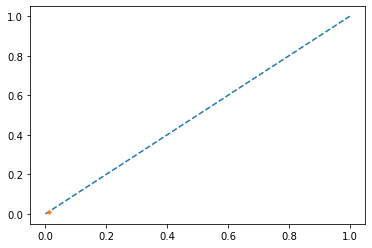

In [27]:
# keep probabilities for the positive outcome only
probs = probs_classes[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_experimental, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
#plt.show()
plt.savefig('../results/calibration_model_morgan_r2_2048_rf_1224857_bruno_imbalanced.png', dpi=300)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.015374, G-Mean=0.758


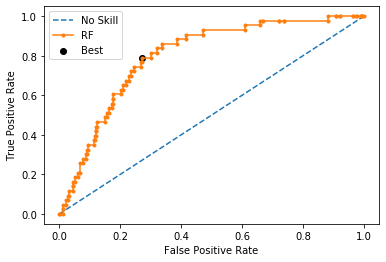

In [28]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_experimental, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RF')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
#plt.show()
plt.savefig('../results/calibration_curve_morgan_r2_2048_rf_1224857_bruno_imbalanced.png', dpi=300)

In [29]:
# Record the threshold in a variable
threshold_roc = thresholds[ix]
print(threshold_roc)

0.015374414797398081


### Optimal Threshold for Precision-Recall Curve

In [30]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_experimental, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.037136, F-Score=nan


C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [31]:
# Record the threshold in a variable
threshold_prc = thresholds[ix]
print(threshold_prc)

0.03713582439504099


### Statistics model calibrated - Choose the best calibration method before

In [32]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_classes[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [33]:
statistics = calc_statistics(y_experimental, pred_rf)

In [34]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "morgan_r2_2048_rf"

result_type = "calibrated"

metrics_rf_calibrated = statistics
metrics_rf_calibrated['model'] = model_type
metrics_rf_calibrated['result_type'] = result_type
metrics_rf_calibrated['calibration_threshold'] = threshold_roc
print("Calibrated model:")
metrics_rf_calibrated

Calibrated model:


,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,F1-score,model,result_type,calibration_threshold
0,0.75,0.77,0.73,0.03,1.0,0.04,0.75,0.12,0.73,0.27,0.27,0.23,0.06,morgan_r2_2048_rf,calibrated,0.015374


In [35]:
# Saving the dataframe as excel file
#metrics_rf_calibrated.to_excel("../results/model_binary_metrics_rf_morgan_r2_gmean_1224857_bruno_imbalanced_thres028.xlsx", sheet_name= "Sheet1")

### Save model

In [36]:
#Save model - pkl file
joblib.dump(opt_rf, "../models/model_binary_rf_morgan_r2_2048_gmean_1224857_bruno_imbalanced.pkl", compress=3)

['../models/model_binary_rf_morgan_r2_2048_gmean_1224857_bruno_imbalanced.pkl']

## SVM Model building - Bayesian hyperparameter search  

In [37]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_svm = BayesSearchCV(
    SVC(probability=True),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'kernel': ['rbf'],  # categorical parameter | ['linear', 'poly', 'rbf'] to test all kernels
    },
    n_iter=50, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

opt_svm.fit(x, y)

print("Best parameters: %s" % opt_svm.best_params_)

Best parameters: OrderedDict([('C', 1000000.0), ('gamma', 0.004620333121637281), ('kernel', 'rbf')])


## 5-fold cross-validation

In [38]:
probs_classes = []
#indexes = []
y_test_all = []

for train_index, test_index in cv.split(x, y):
    svm_clf = SVC(**opt_svm.best_params_, probability=True) # model with best parameters
    X_train_folds = x[train_index] # descritors train split
    y_train_folds = np.array(y)[train_index.astype(int)] # label train split
    X_test_fold = x[test_index] # descritors test split
    y_test_fold = np.array(y)[test_index.astype(int)] # label test split
    
    
    svm_clf.fit(X_train_folds, y_train_folds) # train fold
    y_pred = svm_clf.predict_proba(X_test_fold) # test fold
    probs_classes.append(y_pred) # all predictions for test folds
    y_test_all.append(y_test_fold) # all folds' labels 
#  indexes.append(test_index) # all tests indexes

## Check performance of each fold

In [39]:
# Get predictions of each fold
fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

In [40]:
# Get experimental values of each fold
fold_1_exp = y_test_all[0]
fold_2_exp = y_test_all[1]
fold_3_exp = y_test_all[2]
fold_4_exp = y_test_all[3]
fold_5_exp = y_test_all[4]

In [41]:
bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
print("Balanced accuracy (fold 1) = ", bacc1)
print("Balanced accuracy (fold 2) = ", bacc2)
print("Balanced accuracy (fold 3) = ", bacc3)
print("Balanced accuracy (fold 4) = ", bacc4)
print("Balanced accuracy (fold 5) = ", bacc5)

Balanced accuracy (fold 1) =  0.4978448275862069
Balanced accuracy (fold 2) =  0.5
Balanced accuracy (fold 3) =  0.5
Balanced accuracy (fold 4) =  0.5
Balanced accuracy (fold 5) =  0.5


## Check mean performance of folds

In [42]:
probs_classes = np.concatenate(probs_classes)    
y_experimental = np.concatenate(y_test_all)

In [43]:
# Uncalibrated model predictions
pred_svm = (probs_classes[:, 1] > 0.5).astype(int)

### Statistics - morgan-SVM

In [44]:
# Uncalibrated model predictions
pred_svm = (probs_classes[:, 1] > 0.5).astype(int)
len(y_experimental)

3521

In [45]:
statistics = calc_statistics(y_experimental, pred_svm)

In [46]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "morgan_r2_2048_svm"

result_type = "uncalibrated"

metrics_svm_uncalibrated = statistics
metrics_svm_uncalibrated['model'] = model_type
metrics_svm_uncalibrated['result_type'] = result_type
print("Uncalibrated model:")
metrics_svm_uncalibrated

Uncalibrated model:


,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,F1-score,model,result_type
0,0.5,0.0,1.0,0.0,0.99,-0.0,0.5,-0.0,0.99,0.01,0.0,1.0,0.0,morgan_r2_2048_svm,uncalibrated


### Check model calibatrion

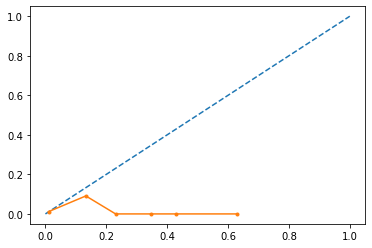

In [47]:
# keep probabilities for the positive outcome only
probs = probs_classes[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_experimental, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
#plt.show()
plt.savefig('../results/calibration_model_morgan_r2_2048_svm_1224857_bruno_imbalanced.png', dpi=300)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.011590, G-Mean=0.709


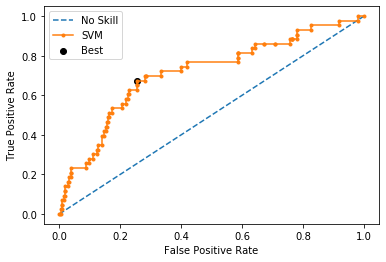

In [48]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_experimental, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
#plt.show()
plt.savefig('../results/calibration_curve_morgan_r2_2048_svm_1224857_bruno_imbalanced.png', dpi=300)

In [49]:
# Record the threshold in a variable
threshold_roc = thresholds[ix]
print(threshold_roc)

0.011589898067047329


### Optimal Threshold for Precision-Recall Curve

In [50]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_experimental, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.202494, F-Score=nan


C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [51]:
# Record the threshold in a variable
threshold_prc = thresholds[ix]
print(threshold_prc)

0.20249422091598057


### Statistics model calibrated - Choose the best calibration method before

In [52]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_classes[:, 1] > threshold_roc).astype(int)
# pred_svm = (probs_classes[:, 1] > threshold_prc).astype(int)

In [53]:
statistics = calc_statistics(y_experimental, pred_svm)

In [54]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "morgan_r2_2048_svm"

result_type = "calibrated"

metrics_svm_calibrated = statistics
metrics_svm_calibrated['model'] = model_type
metrics_svm_calibrated['result_type'] = result_type
metrics_svm_calibrated['calibration_threshold'] = threshold_roc
print("Calibrated model:")
metrics_svm_calibrated

Calibrated model:


,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,F1-score,model,result_type,calibration_threshold
0,0.7,0.65,0.74,0.03,0.99,0.04,0.7,0.1,0.74,0.26,0.26,0.35,0.06,morgan_r2_2048_svm,calibrated,0.01159


In [55]:
# Saving the dataframe as excel file
#metrics_svm.to_excel("../results/model_binary_metrics_svm_morgan_r2_gmean_1224857_bruno_imbalanced_thres039.xlsx", sheet_name= "Sheet1")

### Save model

In [56]:
#Save model - pkl file
joblib.dump(opt_svm, "../models/model_binary_svm_morgan_r2_2048_gmean_1224857_bruno_imbalanced.pkl", compress=3)

['../models/model_binary_svm_morgan_r2_2048_gmean_1224857_bruno_imbalanced.pkl']

## LightGBM Model building - Bayesian hyperparameter search

In [57]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_lgb = BayesSearchCV(lgb.LGBMClassifier(),
                        {'learning_rate': (0.01, 1.0, 'log-uniform'), 
                         'num_leaves': (7, 4095),
                         'n_estimators': (100, 800), 
                         'max_depth': (2, 63),
                         'subsample': (0.4, 1), 
                         'scale_pos_weight': (1, 1000)}, 
                        n_iter = 50, # Number of parameter settings that are sampled
                        cv = cv, 
                        scoring = scorer,
                        refit = True, # Refit the best estimator with the entire dataset.
                        verbose = 0,
                        random_state = 42, 
                        n_jobs = 1)

opt_lgb.fit(x, y)

print("Best parameters: %s" % opt_lgb.best_params_)

Best parameters: OrderedDict([('learning_rate', 0.01), ('max_depth', 26), ('n_estimators', 457), ('num_leaves', 7), ('scale_pos_weight', 1000), ('subsample', 0.884911047704567)])


## 5-fold cross-validation

In [58]:
probs_classes = []
#indexes = []
y_test_all = []

for train_index, test_index in cv.split(x, y):
    lgb_clf = lgb.LGBMClassifier(**opt_lgb.best_params_,) # model with best parameters
    X_train_folds = x[train_index] # descritors train split
    y_train_folds = np.array(y)[train_index.astype(int)] # label train split
    X_test_fold = x[test_index] # descritors test split
    y_test_fold = np.array(y)[test_index.astype(int)] # label test split
    
    
    svm_clf.fit(X_train_folds, y_train_folds) # train fold
    y_pred = svm_clf.predict_proba(X_test_fold) # test fold
    probs_classes.append(y_pred) # all predictions for test folds
    y_test_all.append(y_test_fold) # all folds' labels 
#  indexes.append(test_index) # all tests indexes

## Check performance of each fold

In [59]:
# Get predictions of each fold
fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

In [60]:
# Get experimental values of each fold
fold_1_exp = y_test_all[0]
fold_2_exp = y_test_all[1]
fold_3_exp = y_test_all[2]
fold_4_exp = y_test_all[3]
fold_5_exp = y_test_all[4]

In [61]:
bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
print("Balanced accuracy (fold 1) = ", bacc1)
print("Balanced accuracy (fold 2) = ", bacc2)
print("Balanced accuracy (fold 3) = ", bacc3)
print("Balanced accuracy (fold 4) = ", bacc4)
print("Balanced accuracy (fold 5) = ", bacc5)

Balanced accuracy (fold 1) =  0.5
Balanced accuracy (fold 2) =  0.5
Balanced accuracy (fold 3) =  0.5
Balanced accuracy (fold 4) =  0.5
Balanced accuracy (fold 5) =  0.5


## Check mean performance of folds

In [62]:
probs_classes = np.concatenate(probs_classes)    
y_experimental = np.concatenate(y_test_all)

In [63]:
# Uncalibrated model predictions
pred_lgb = (probs_classes[:, 1] > 0.5).astype(int)

### Statistics - morgan-LGB

In [64]:
pred_lgb = (probs_classes[:, 1] > 0.5).astype(int)

In [65]:
statistics = calc_statistics(y_experimental, pred_lgb)

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [66]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "morgan_r2_2048_lgb"

result_type = "uncalibrated"

metrics_lgb_uncalibrated = statistics
metrics_lgb_uncalibrated['model'] = model_type
metrics_lgb_uncalibrated['result_type'] = result_type
print("Uncalibrated model:")
metrics_lgb_uncalibrated

Uncalibrated model:


,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,F1-score,model,result_type
0,0.5,0.0,1.0,NaN,0.99,0.0,0.5,0.0,0.99,0.01,0.0,1.0,0.0,morgan_r2_2048_lgb,uncalibrated


### Check model calibatrion

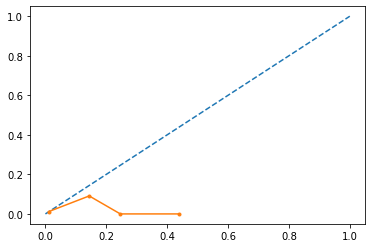

In [67]:
# keep probabilities for the positive outcome only
probs = probs_classes[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_experimental, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
#plt.show()
plt.savefig('../results/calibration_model_morgan_r2_2048_lgb_1224857_bruno_imbalanced.png', dpi=300)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.011601, G-Mean=0.703


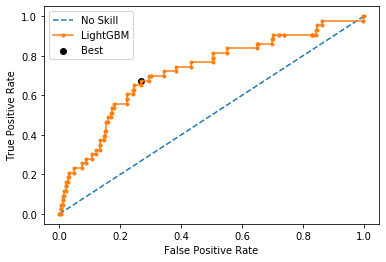

In [68]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_experimental, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
#plt.show()
plt.savefig('../results/calibration_curve_morgan_r2_2048_lgb_1224857_bruno_imbalanced.png', dpi=300)

In [69]:
# Record the threshold in a variable
threshold_roc = thresholds[ix]
print(threshold_roc)

0.011600616889588215


### Optimal Threshold for Precision-Recall Curve

In [70]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_experimental, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.153583, F-Score=nan


C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [71]:
# Record the threshold in a variable
threshold_prc = thresholds[ix]
print(threshold_prc)

0.15358341449916227


### Statistics model calibrated - Choose the best calibration method before

In [72]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_classes[:, 1] > threshold_roc).astype(int)
# pred_lgb = (probs_classes[:, 1] > threshold_prc).astype(int)

In [73]:
statistics = calc_statistics(y_experimental, pred_lgb)

In [74]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "morgan_r2_2048_lgb"

result_type = "calibrated"

metrics_lgb_calibrated = statistics
metrics_lgb_calibrated['model'] = model_type
metrics_lgb_calibrated['result_type'] = result_type
metrics_lgb_calibrated['calibration_threshold'] = threshold_roc
print("Calibrated model:")
metrics_lgb_calibrated

Calibrated model:


,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,F1-score,model,result_type,calibration_threshold
0,0.69,0.65,0.73,0.03,0.99,0.03,0.69,0.09,0.73,0.27,0.27,0.35,0.06,morgan_r2_2048_lgb,calibrated,0.011601


In [75]:
# Saving the dataframe as excel file
#metrics_lgb.to_excel("../results/model_binary_metrics_lgb_morgan_bee_1224857_bruno_imbalanced_gmean_NO_classweight_thres029.xlsx", sheet_name= "Sheet1")

### Save model

In [76]:
#Save model - pkl file
joblib.dump(opt_lgb, "../models/model_binary_lgb_morgan_r2_2048_gmean_1224857_bruno_imbalanced.pkl", compress=3)

['../models/model_binary_lgb_morgan_r2_2048_gmean_1224857_bruno_imbalanced.pkl']

## Compare all models

## Save an excell with all results - models uncalibrated

In [79]:
frames = [metrics_rf_uncalibrated, metrics_svm_uncalibrated, metrics_lgb_uncalibrated, 
          metrics_rf_calibrated, metrics_svm_calibrated, metrics_lgb_calibrated]

result = pd.concat(frames)

column_names = ["model", "Bal-acc", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "Kappa", "MCC", "AUC", "F1-score", 
                "Classification error", "False positive rate", "False negative rate", "result_type", "calibration_threshold"]

result = result.reindex(columns=column_names)

result

,model,Bal-acc,Accuracy,Sensitivity,Specificity,PPV,NPV,Kappa,MCC,AUC,F1-score,Classification error,False positive rate,False negative rate,result_type,calibration_threshold
0,morgan_r2_2048_rf,0.50,0.99,0.00,1.00,NaN,0.99,0.00,0.00,0.50,0.00,0.01,0.00,1.00,uncalibrated,NaN
0,morgan_r2_2048_svm,0.50,0.99,0.00,1.00,0.00,0.99,-0.00,-0.00,0.50,0.00,0.01,0.00,1.00,uncalibrated,NaN
0,morgan_r2_2048_lgb,0.50,0.99,0.00,1.00,NaN,0.99,0.00,0.00,0.50,0.00,0.01,0.00,1.00,uncalibrated,NaN
0,morgan_r2_2048_rf,0.75,0.73,0.77,0.73,0.03,1.00,0.04,0.12,0.75,0.06,0.27,0.27,0.23,calibrated,0.015374
0,morgan_r2_2048_svm,0.70,0.74,0.65,0.74,0.03,0.99,0.04,0.10,0.70,0.06,0.26,0.26,0.35,calibrated,0.011590
0,morgan_r2_2048_lgb,0.69,0.73,0.65,0.73,0.03,0.99,0.03,0.09,0.69,0.06,0.27,0.27,0.35,calibrated,0.011601


In [80]:
# Saving the dataframe as excel file
result.to_excel("../results/metrics_binary_morgan_r2_2048_allmodels_1224857_bruno_imbalanced.xlsx", sheet_name= "Sheet1")